# Training main model on preprocessed data, evaluate it and show a prediction

In [20]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2023-12-03 15:45:03--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  3.08MB/s    in 1.5s    

2023-12-03 15:45:05 (3.08 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [4]:
# !pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163752 sha256=3c30aa2e0ab5e6d1e0d1e1468297add001ed4243585d4e281a438e1c478cb55a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [14]:
# import useful libraries
import pickle
import numpy as np
import pandas as pd
from IPython.display import display_html
import warnings
from sklearn.model_selection import train_test_split
from surprise import SVD
import numpy as np
import surprise
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

base = "/content/ml-100k/"

%matplotlib inline

In [21]:
# load rating and user data
ratings_data = pd.read_csv(base + 'u.data', sep = '\t', header = None)
ratings_data.columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_data.head(10)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [47]:
class Preprocessor:
    def __init__(self, items, users):
        """
        Initialize nessesary models and objects

        :param items: dataframe of movies
        :param users: dataframe of users
        """
        self.reader = Reader(rating_scale=(1,5))

        # SVD model for additional features
        self.svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
        self.users = users
        self.items = items
        self.train_sparse_matrix = None
        self.train_averages = dict()
        self.col_names = ['M', 'F'] + ["occupation_" + str(i + 1) for i in range(len(users['occupation'].unique()))]
        self.encoder = None

    def fit_svd(self, df):
        """
        Fitinf SVD model on train data

        :param df: train dataset
        """
        # Building special form dataset and fit SVD
        train_data_mf = Dataset.load_from_df(df[['user_id',
                                                           'item_id',
                                                           'rating']],
                                                 self.reader)
        trainset = train_data_mf.build_full_trainset()
        self.svd.fit(trainset)
        return trainset

    def get_average_ratings(self, of_users = True):
        """
        Calculating average rating for movies and users using User-Movie matrix

        :param of_user: boolean parameter controls switching between users and items
        :return: average rating
        """
        # Choose axes for users or movies
        ax = 1 if of_users else 0 # 1 - User axes, 0 - Movie axes
        sum_of_ratings = self.train_sparse_matrix.sum(axis = ax).A1
        # Whether a user rated that movie or not
        is_rated = self.train_sparse_matrix != 0
        no_of_ratings = is_rated.sum(axis=ax).A1

        # Maximum number of users and movies
        u, m = self.train_sparse_matrix.shape

        # Create a dictionary of users and their average ratings
        # Zero is in case of movie not presenting in ratings
        average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] if no_of_ratings[i] !=0 else 0
                        for i in range(u if of_users else m)}
        return average_ratings

    def top_users_rates(self, user, movie, k = 5):
        """
        Get rating for movie from most similar users

        :param user: user id
        :param movie: movie id
        :param k: number of similar users
        :return: rating of the most similar users
        """
        # Find nearest users for our user
        user_sim = cosine_similarity(self.train_sparse_matrix[user],
                                     self.train_sparse_matrix).ravel()
        # Sort by similarity and remove user himself
        # And take rating for this movie by the most similar users
        top_sim_users = user_sim.argsort()[::-1][1:]
        top_ratings = self.train_sparse_matrix[top_sim_users, movie].toarray().ravel()

        # If number of similar users less than k, fill by average for this movie
        top_sim_users_ratings = list(top_ratings[top_ratings != 0][:k])
        top_sim_users_ratings.extend([self.train_averages['movie'][movie]]*(k - len(top_sim_users_ratings)))
        return top_sim_users_ratings

    def top_movie_rates(self, user, movie, k = 5):
        """
        Get rating from user for most similar movies

        :param user: user id
        :param movie: movie id
        :param k: number of similar movies
        :return: rating of the most similar movies
        """
        # Find nearest movies for our movie
        movie_sim = cosine_similarity(self.train_sparse_matrix[:,movie].T,
                                      self.train_sparse_matrix.T).ravel()
        top_sim_movies = movie_sim.argsort()[::-1][1:]
        # Sort by similarity and remove movie himself
        # And take rating for movies most similar to current
        top_ratings = self.train_sparse_matrix[user, top_sim_movies].toarray().ravel()

        # If number of similar movies less than k, fill by average for this user
        top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:k])
        top_sim_movies_ratings.extend([self.train_averages['user'][user]]*(k - len(top_sim_movies_ratings)))
        return top_sim_movies_ratings

    def one_hot_encoding(self, df, encoder = None):
        """
        OneHot encoding

        :param df: dataframe to be encoded
        :param encoder: onehot encoder itself
        :return: encoder and encoded dataframe
        """
        # Converting type of columns to category
        df['gender'] = df['gender'].astype('category')
        df['occupation'] = df['occupation'].astype('category')

        if encoder:
            # For existing encoder
            enc_data = pd.DataFrame(encoder.transform(
            df[['gender', 'occupation']]).toarray(), columns=self.col_names)
        else:
            # Create new encoder and fit it
            encoder = OneHotEncoder()
            enc_data = pd.DataFrame(encoder.fit_transform(
            df[['gender', 'occupation']]).toarray(), columns=self.col_names)

        final_df = df.join(enc_data).drop(['gender', 'occupation'], axis = 1)

        return encoder, final_df

    def best_values(self, df, rated = False, k = 5):
        """
        Additional features based on similar user, similar movie and their average value

        :param df: dataframe to be encoded
        :param rated: was the data rated
        :param k: numer of similar movies/users
        :return: encoded data
        """
        data = df
        for i in tqdm(data.index):
            # Extract user and movie
            user = data.loc[i]['user_id']
            movie = data.loc[i]['item_id']

            # Get rating of most similar users and movies
            top_users_list = self.top_users_rates(user, movie, k = k)
            top_movie_list = self.top_movie_rates(user, movie, k = k)
            movies_columns = ["M" + str(i+1) for i in range(k)]
            users_columns = ["U" + str(i+1) for i in range(k)]

            # Average this values
            if rated:
                UAvg = data.loc[data['user_id'] == user, 'rating'].mean()
                MAvg = data.loc[data['item_id'] == movie, 'rating'].mean()
            else:
                UAvg = np.mean(top_users_list)
                MAvg = np.mean(top_movie_list)

            # Extend initial data
            columns = tuple(users_columns + movies_columns + ['UAvg', 'MAvg'])
            values = top_users_list + top_movie_list + [UAvg, MAvg]
            data.at[i, columns] = values
        return data

    def preprocess(self, df, set_type = 'Train'):
        """
        Preprocessor

        :param df: initial data
        :param set_type: Train/Test/Predict
        :return: preprocessed data
        """
        if set_type == 'Train':
            # Fit SVD, User-Item matrix and OneHot encoder on test data
            trainset = self.fit_svd(df)
            max_users = self.users['user_id'].max()
            max_items = self.items['item_id'].max()
            self.train_sparse_matrix = csr_matrix((df.rating.values,
             (df.user_id.values, df.item_id.values)),
                                 shape = (max_users + 1, max_items + 1))
            self.train_averages['global'] = self.train_sparse_matrix.sum()/self.train_sparse_matrix.count_nonzero()
            self.train_averages['user'] = self.get_average_ratings(of_users = True)
            self.train_averages['movie'] = self.get_average_ratings(of_users = False)

            final_train_data = self.best_values(df, rated = True)
            self.encoder, one_hot_train = self.one_hot_encoding(final_train_data)
            one_hot_train = one_hot_train.drop(['timestamp', 'zip code', 'item_title', 'release_date',
                                       'video_release_date', 'IMDb_URL'],
                                      axis=1)
            # Normalize age and add additional features from SVD predictions
            one_hot_train['age'] = one_hot_train['age']/100
            train_preds = self.svd.test(trainset.build_testset())
            train_pred_mf = np.array([pred.est for pred in train_preds])
            one_hot_train = one_hot_train.join(pd.DataFrame(train_pred_mf, columns=['pred']))
            return one_hot_train

        elif set_type == 'Test':
            # Use OneHot encoder to encode gender and occupation
            final_test = self.best_values(df, rated = True)
            _, one_hot_test = self.one_hot_encoding(final_test, encoder = self.encoder)
            one_hot_test = one_hot_test.drop(['timestamp', 'zip code', 'item_title', 'release_date',
                                       'video_release_date', 'IMDb_URL'],
                                      axis=1)
            # Normalize age and add additional features from SVD predictions
            one_hot_test['age'] = one_hot_test['age']/100

            test_data_mf = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], self.reader)
            testset = test_data_mf.build_full_trainset()
            test_preds = self.svd.test(testset.build_testset())
            test_pred_mf = np.array([pred.est for pred in test_preds])
            one_hot_test = one_hot_test.join(pd.DataFrame(test_pred_mf, columns=['pred']))
            return one_hot_test

        else:
            # Use OneHot encoder to encode gender and occupation
            final_test = self.best_values(df, rated = False)
            _, one_hot_pred = self.one_hot_encoding(final_test, encoder = self.encoder)
            rank = pd.DataFrame([0 for i in range(len(one_hot_pred))], columns=['ranking'])
            one_hot_pred = one_hot_pred.join(pd.DataFrame(rank, columns=['rating']))

            # Normalize age and add additional features from SVD predictions
            test_data_mf = Dataset.load_from_df(one_hot_pred[['user_id', 'item_id', 'rating']], self.reader)
            testset = test_data_mf.build_full_trainset()
            test_preds = self.svd.test(testset.build_testset())
            test_pred_mf = np.array([pred.est for pred in test_preds])
            one_hot_pred = one_hot_pred.join(pd.DataFrame(test_pred_mf, columns=['pred']))
            one_hot_pred['age'] = (one_hot_pred['age']/100).astype('float')

            one_hot_pred = one_hot_pred.drop(['user_id', 'zip code',
                                                        'item_title', 'release_date',
                                                        'video_release_date', 'IMDb_URL',
                                                        'rating'], axis=1)
            return one_hot_pred

In [48]:
# Restore preprocessor
with open('preprocessor.pkl', 'rb') as inp:
    preprocessor = pickle.load(inp)

In [49]:
final_train_data = pd.read_csv('train_data_preprocessed.csv')
final_test_data = pd.read_csv('test_data_preprocessed.csv')

In [50]:
# Prepare train data
y_train = final_train_data['rating']
x_train = final_train_data.drop(['user_id', 'item_id','rating'], axis=1)
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(silent=False, n_jobs=13,random_state=15,n_estimators=100)
# Fit the model
xgb_model.fit(x_train, y_train, eval_metric = 'rmse')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=13,
             num_parallel_tree=None, random_state=15, ...)

In [51]:
# Save model
xgb_model.save_model("model.json")

In [ ]:
# # Restore model
# xgb_model = xgb.XGBRegressor(silent=False, n_jobs=13,random_state=15,n_estimators=100)
# xgb_model.load_model("model.json")

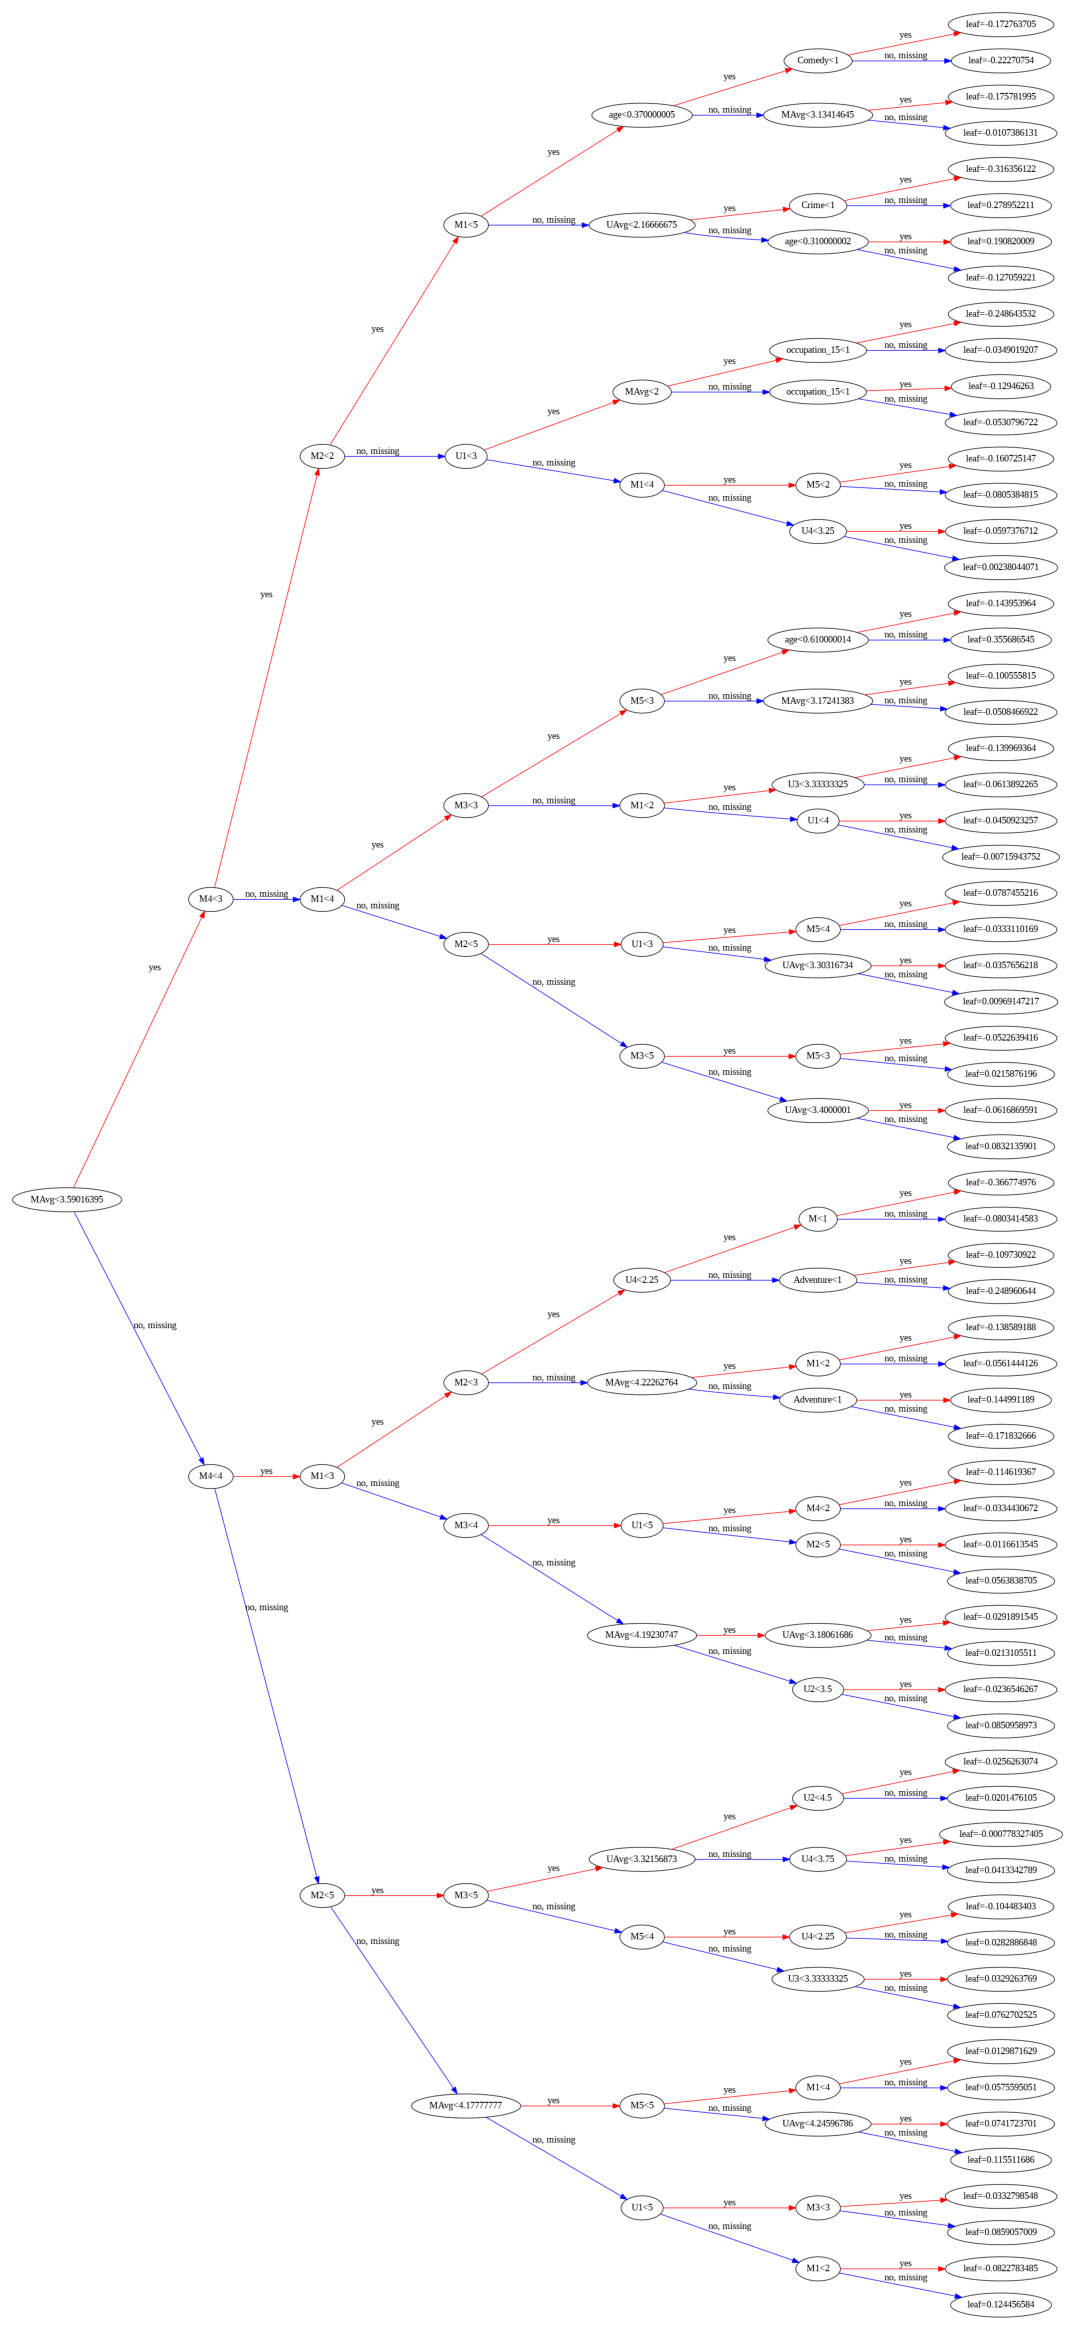

In [52]:
# Plot resulting tree
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgb_model, num_trees=4, ax=ax, rankdir='LR')
plt.savefig("temp.png")
plt.show()

In [53]:
# Prepare test data
y_test = final_test_data['rating']
x_test = final_test_data.drop(['user_id', 'item_id','rating'], axis=1)

In [42]:
def MAPE_func(true, pred):
    """
    Mean absolute percentage error

    :param true: true labels
    :param predL predicted labels
    """
    return np.mean(np.abs((true - pred)/true)) * 100

def RMSE_func(true, pred):
    """
    Root mean square error

    :param true: true labels
    :param predL predicted labels
    """
    return np.sqrt(np.mean([(true[i] - pred[i])**2 for i in range(len(pred))]))

In [54]:
# Dictionaries for storing train and test results
test_results = dict()
# From the trained model, get the predictions
y_test_pred = xgb_model.predict(x_test)
# Get the rmse and mape of train data
rmse = RMSE_func(y_test.values, y_test_pred)
mape = MAPE_func(y_test.values, y_test_pred)
# Store the results in train_results dictionary
test_results = {'RMSE': rmse, 'MAPE' : mape}
print(f"RMSE: {np.round(rmse, 4)}\nMAPE: {np.round(mape, 4)}")

RMSE: 0.8792
MAPE: 26.3281


Achived 0.879 RMSE and 26.3 MAPE, which may be considered as good result

# Recommendation check

In [61]:
def predict(user_id, rates, model, k = 5):
    """
    Recommend movies for user

    :param user_id: id of user
    :param rates: data with existing ratings
    :param model: trained model
    :param k: number of recommended movies
    :return: list of movies
    """

    # Find movies which user hasn't watched yet
    movies = preprocessor.items
    users = preprocessor.users
    merged = pd.merge(rates, users)
    movies_list = merged[merged['user_id'] == user_id]['item_id']
    user_unseen = movies[~movies['item_id'].isin(movies_list)]

    # Preprocess data
    merged_data = pd.merge(users.loc[user_id].to_frame().T, user_unseen, how='cross')
    best_data = preprocessor.preprocess(merged_data, set_type = 'Predict')

    # Make model prediction
    predictions = model.predict(best_data.drop(['item_id'], axis = 1))

    # Find the most highly rated items
    dict_preds = {x:predictions[i] for i, x in enumerate(best_data['item_id'])}
    best_films = [a for a,b in sorted(dict_preds.items(), key=lambda x:x[1], reverse=True)][:k]
    return list(movies[movies['item_id'].isin(best_films)]['item_title'])

user_idx = 1
test_items_list = predict(user_idx, ratings_data, xgb_model)
print(f'\nFor user {user_idx} we recommend to watch:')
for it in test_items_list:
    print(it)

100%|██████████| 1410/1410 [00:16<00:00, 84.51it/s]
For user 1 we recommend to watch:
Manchurian Candidate, The (1962)
C'est arrivé près de chez vous (1992)
They Made Me a Criminal (1939)
Star Kid (1997)
Saint of Fort Washington, The (1993)


# Reference:
[1] - F. M. Harper and J. A. Konstan, “The MovieLens datasets: History and context,” ACM Trans. Interact. Intell. Syst., vol. 5, no. 4, pp. 1–19, 2016. http://dx.doi.org/10.1145/2827872

[2] - F. M. Harper and J. A. Konstan, “The MovieLens datasets: History and context,” ACM Trans. Interact. Intell. Syst., vol. 5, no. 4, pp. 1–19, 2016.

[3] - R. Vidiyala, “How to build a movie recommendation system,” Towards Data Science, 02-Oct-2020. [Online]. Available: https://towardsdatascience.com/how-to-build-a-movie-recommendation-system-67e321339109. [Accessed: 03-Dec-2023].

[4] - P. Aher, “Evaluation metrics for recommendation systems — an overview,” Towards Data Science, 09-Aug-2023. [Online]. Available: https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba. [Accessed: 03-Dec-2023].

[5] - “Recommendation system in python,” GeeksforGeeks, 18-Jul-2021. [Online]. Available: https://www.geeksforgeeks.org/recommendation-system-in-python/. [Accessed: 03-Dec-2023].